<a href="https://colab.research.google.com/github/SanjibSarkarU/colab-NN/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
!pip install tensorflow-gpu

In [136]:
import numpy as np
import tensorflow as tf
# from tensorflow.keras.models import Sequential
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [137]:
df = pd.read_csv('20220222_153859_hlc.csv', skiprows=1)
df = df.rename(columns={"Latitude (Deg N)": 'lat', "Longitude (Deg W)": 'lng'}, errors="raise")
df = df.loc[(df['lat'] != 0)]

In [138]:
# df.dtypes

In [139]:
#  df.lat.plot()

In [140]:
start = 10500
end = 13700
series_time = df.Time[start:end].to_numpy()
series_lat = df.lat[start:end].to_numpy()
series_lng = df.lng[start:end].to_numpy()
xaxis = np.array([i for i in range(len(series_lat))])

In [141]:
# type(series_lat)
xaxis.shape


(3200,)

In [142]:
series_lat

array([30.35248509, 30.35248803, 30.35248947, ..., 30.35157004,
       30.35157101, 30.35157185])

In [143]:
def plot_dataset(xaxis, yaxis, xlabel= 'xaxis', ylabel= 'yaxis', color='r'):
  plt.plot(xaxis, yaxis, color=color)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

In [144]:
def train_test_split(dataset, percentage):
  train_size = int(len(dataset)*percentage)
  test_seze = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train, test

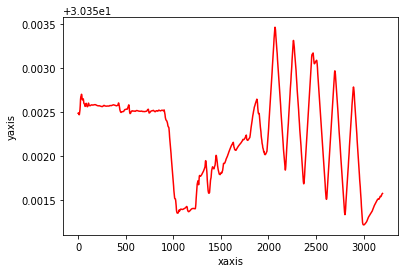

In [145]:
plot_dataset(xaxis, series_lat)

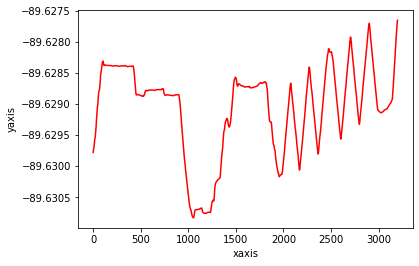

In [146]:
plot_dataset(xaxis, series_lng)

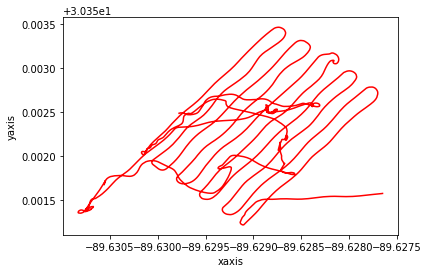

In [147]:
plot_dataset(series_lng, series_lat)

In [148]:
# reshape
series_lat = np.reshape(series_lat,(len(series_lat),1))
series_lng = np.reshape(series_lng,(len(series_lng),1))
xaxis = np.reshape(xaxis,(len(xaxis),1))

In [149]:
# # Normalization is optional but recommended for neural network as certain 
# # activation functions are sensitive to magnitude of numbers. 
# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer

In [150]:
# series_lat = scaler.fit_transform(series_lat)
# # series_lng = scaler.fit_transform(series_lng)

In [151]:
# split into train and test sets
train_lat, test_lat = train_test_split(series_lat, 0.7)
train_lng, test_lng = train_test_split(series_lng, 0.7)
train_xaxis, test_xaxis = train_test_split(xaxis, 0.7)
train_lat.shape

(2240, 1)

In [152]:
tl= test_lat

In [153]:
# train_lat

In [154]:
def test_data_preparation(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    # dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [155]:
from keras.preprocessing.sequence import TimeseriesGenerator
def ts_data_preparation(features, window_size=5, future=1, batch_size =1, shuffle=False):
  target = features[(future-1):]
  features = features[:-(future-1)] if future != 1 else features   
  tensor = TimeseriesGenerator(features, target, length=window_size, batch_size=batch_size, shuffle=shuffle)
  return tensor


In [156]:
window_size=15
future =
batch_size= 32
train_x_lat = ts_data_preparation(train_lat, window_size=window_size, future=future, batch_size=batch_size, shuffle=True)
train_x_lng = ts_data_preparation(train_lng, window_size=window_size, future=future, batch_size=batch_size, shuffle=True)

In [157]:
test_lat = test_data_preparation(test_lat, window_size=window_size, batch_size=batch_size)

In [158]:
# for data in test_lat:
#   print('X' * 100)
#   print(data.numpy())
#   break

In [159]:
# train_x_lat[0]

In [160]:
len(train_x_lat)

70

In [161]:
#Stacked LSTM with 1 hidden dense layer
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# activation='relu'
tf.keras.backend.clear_session()
def model_lstm(window_size):
  
  model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(window_size,1)),
                    tf.keras.layers.LSTM(50, activation='relu'),
                    tf.keras.layers.Dense(1)])
  model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
                loss='mse')
  model.summary()
  # print('Train...', model.summary())
  return model

In [162]:
model = model_lstm(window_size)
epochs = 50
model.fit(train_x_lat, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 6s 34ms/step - loss: 78.2491
Epoch 2/50
70/70 [==============================] - 3s 39ms/step - loss: 0.0155
Epoch 3/50
70/70 [==============================] - 2s 34ms/step - loss: 9.7045e-06
Epoch 4/50
70/70 [==============================] - 3s 38ms/step - loss

In [163]:
testPredict_lat = model.predict(test_lat)

In [164]:
# testPredict_lat

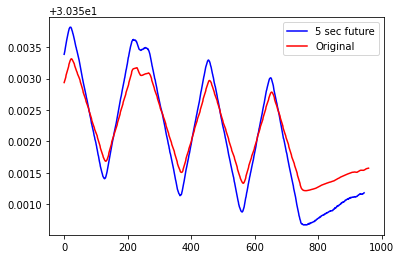

In [165]:
plt.plot(testPredict_lat, color='b', label=f'{future} sec future')
plt.plot(tl, color = 'r', label = 'Original')
plt.legend()

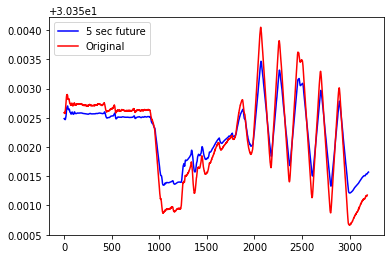

In [166]:
predict_all_lat = model.predict(test_data_preparation(series_lat, window_size=window_size, batch_size=batch_size))
plt.plot(series_lat, color ='b', label= f'{future} sec future' )
plt.plot(predict_all_lat, color = 'r', label = 'Original')
plt.legend()